In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from biosppy.signals import ecg
import os
import neurokit as nk

In [82]:
ecg_data_file = 'D:\data\ibeat\eplab\Subject44_data.hdf'
ecg_data = pd.read_hdf(ecg_data_file, 'eplab')

## cut ecg data

In [83]:
ecg_data = ecg_data[(ecg_data['utc_adjusted']> 1527108380) & (ecg_data['utc_adjusted']<1527108473)]

## Run Biosppy ECG Analysis on chunks:

In [84]:

ecg_chunks = []
print('Analyzing {} chunks'.format(len(ecg_data.section.unique())))
for section in ecg_data.section.unique():
    ecg_section = ecg_data[ecg_data.section == section]

    # Run biosppy ecg analysis
    ecg_analysis = ecg.ecg(signal=ecg_section.II, sampling_rate=976.942, show=False)
    
    ecg_chunks.append(pd.DataFrame(dict(ecg_heart_rate=ecg_analysis['heart_rate'], 
                                        utc=ecg_analysis['heart_rate_ts'] + ecg_section.utc_adjusted.iloc[0])))

# Concatinate results
ecg_analysis = pd.concat(ecg_chunks)

Analyzing 1 chunks


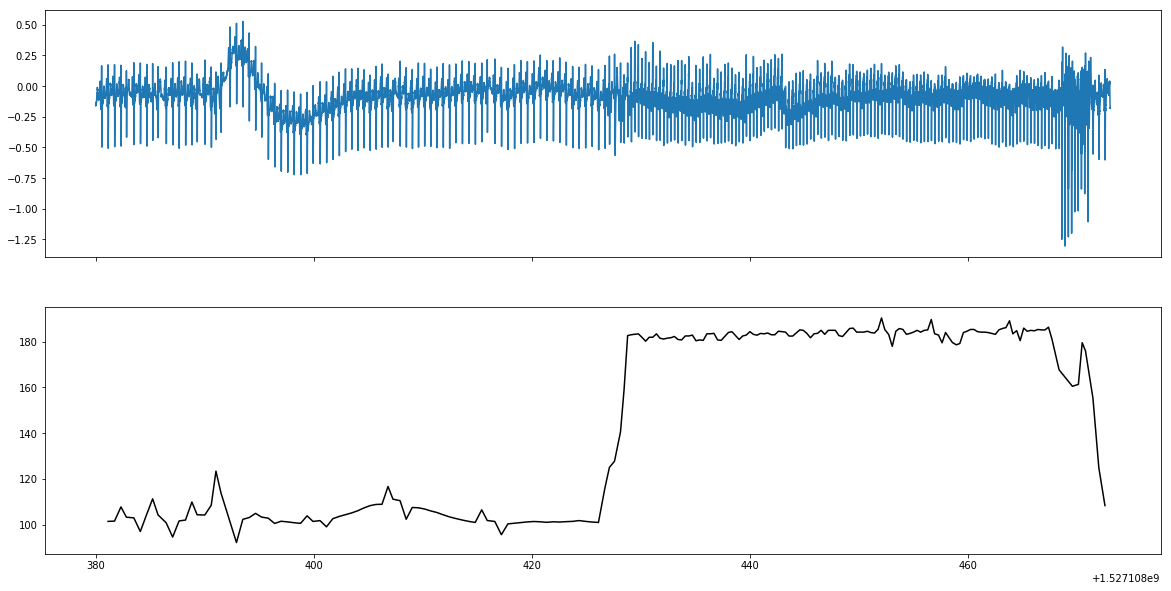

In [85]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

# Raw ECG Signal
ax[0].plot(ecg_data.utc_adjusted, ecg_data.II)

ax[1].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate, c='k', label='ECG Heart Rate')
# ax[-1].set_xlim([ecg_data.utc_adjusted.min(), ecg_data.utc_adjusted.max()])

## Baseline correction and complete the R peaks

In [86]:
SR = 976.942
ecg_sig = ecg_data.II
out = ecg.ecg(signal=ecg_sig, sampling_rate=SR,show = False)
ecg_sig = out['filtered']

# plt.figure(figsize=(20,10))
# plt.plot(out['filtered'])
# plt.title('Baseline corrected ECG signal')

## Two ways to find the indexes of R peaks: neurokit.py & biosppy.py

In [87]:
rpeaks2 = out['rpeaks']

In [88]:
#rpeaks2

## Calculate and visualize RR intervals

In [89]:
rrinterval = []
for i in range(len(rpeaks2)-1):
    rrinterval.append((rpeaks2[i+1]-rpeaks2[i])/SR)

rrinterval[0:5]

[0.5926656853733384,
 0.5895948787133729,
 0.5906184809333614,
 0.500541485574374,
 0.6796718740723605]

In [90]:
# hr = []
# for i in range(len(rrinterval)):
#     hr.append(60/rrinterval[i])
# hr[0:5]

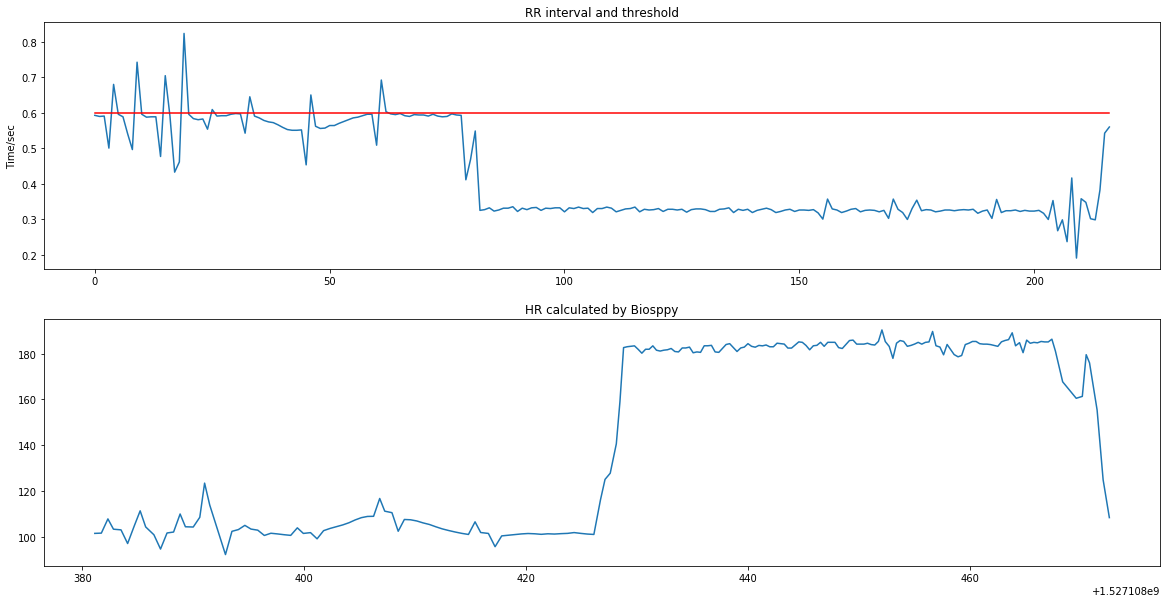

In [91]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(20, 10))
threshold = [0.6] * len(rrinterval)
# Raw ECG Signal
ax[0].plot(rrinterval)
ax[0].plot(threshold, c='r')
ax[0].set_title('RR interval and threshold')
ax[0].set_ylabel('Time/sec')
ax[1].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate)
ax[1].set_title('HR calculated by Biosppy')
plt.rcParams['axes.grid'] = False

## 5 consecutive beats of which the RR intervals are below 600ms

In [96]:
# Extract 5 consecutive RR intervals shorter than 600ms.
# Note: 5 RR intervals = 6 beats when calling rpeaks data
thold_num = 5
index = []
for i in range(len(rrinterval)-thold_num):
    if rrinterval[i] < 0.6 and rrinterval[i+1] < 0.6 and rrinterval[i+2] < 0.6 and rrinterval[i+3] < 0.6 and rrinterval[i+4] < 0.6:
        index.append(i)
index[0:10]

[10, 20, 26, 27, 28, 34, 35, 36, 37, 38]

In [98]:
# group the indices into different tachycardia events
import more_itertools as mit
grouped_index = [list(group) for group in mit.consecutive_groups(index)]
grouped_index[0:5]

[[10],
 [20],
 [26, 27, 28],
 [34, 35, 36, 37, 38, 39, 40, 41],
 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]]

In [99]:
# find the beginning and end point of tachycardia
begin_index = []
end_index = []
for i in range(len(grouped_index)):
    begin_index.append(grouped_index[i][0])
    end_index.append(grouped_index[i][-1] + thold_num)

In [100]:
end_index[0:5]

[15, 25, 33, 46, 61]

In [101]:
for i in begin_index:
    print(rpeaks2[i])

6311
12026
15450
20092
27258
36332


In [102]:
for i in end_index:
    print(rpeaks2[i])

9083
14855
19462
26623
35067
89836


In [78]:
       
# Add 1.5 sec ECG data points before and after Rpeaks where tachycardia occurs.
# begin = []
# end = []
# time_add = 1.5
# data_add = round(time_add*SR)
# for i in range(len(rpeaks_tachy)):
#     begin.append(rpeaks2[begin_index[i]]-data_add)
#     end.append(rpeaks2[end_index[0]+1]]+data_add)



## Extract and plot the tachycardia sections.

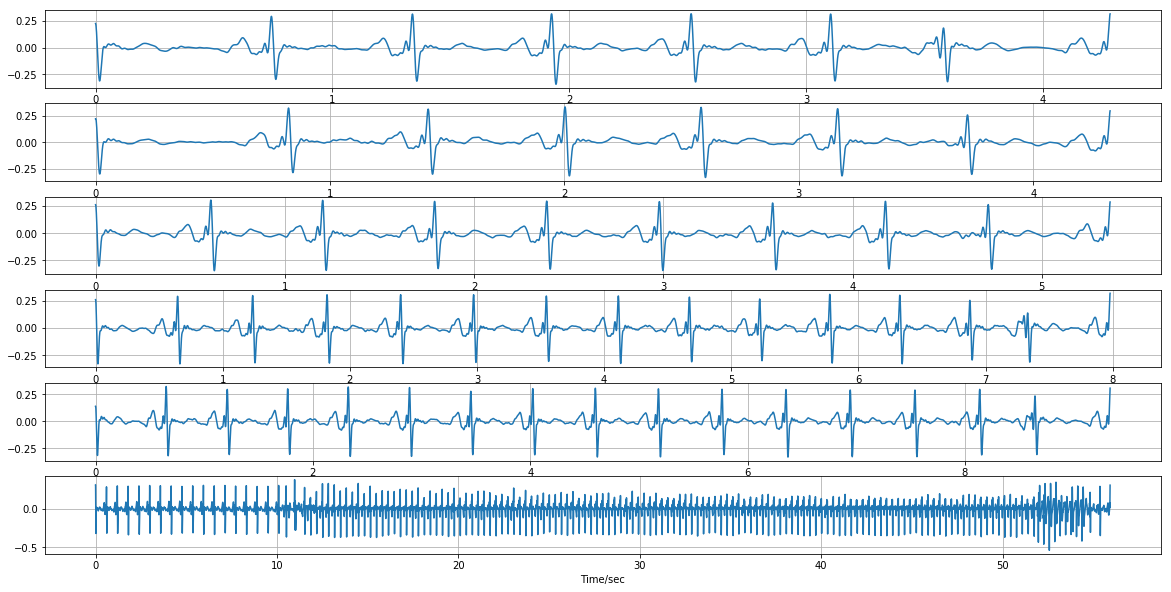

In [107]:
#t  = np.linspace(0, 2*time_add, num=2*data_add)
fig, ax = plt.subplots(len(begin_index), 1, sharex=False, figsize=(20, 10))


for i in range(len(begin_index)):
# Use locals() function to set variable names as tachy1, tachy2, ...
    name = 'tachy'+str(i)
    
# Note that the ith RRinterval is calculated by (i+1)th rpeak minus the ith rpeak.
    locals()['tachy'+str(i)] = ecg_sig[rpeaks2[begin_index[i]-1]:rpeaks2[end_index[i]+1]]
    
# Convert the x axis from index to real time
    locals()['time'+str(i)] = np.linspace(0,(rpeaks2[end_index[i]+1] - rpeaks2[begin_index[i]-1])/SR, num = rpeaks2[end_index[i]+1] - rpeaks2[begin_index[i]-1])
    
    ax[i].plot(locals()['time'+str(i)], locals()['tachy'+str(i)])
    
# x-axis Increase running time significantly
#    ax[i].set_xticks(np.arange(0,(rpeaks2[end_index[i]+1] - rpeaks2[begin_index[i]-1])/SR,0.2))
    
    
    
    plt.xlabel('Time/sec')
    plt.rcParams['axes.grid'] = True
    
# Need to adjust legend size
#    ax[i].legend("{}".format(rpeaks2[begin_index[i]-1]))

#Save subplots to subplot{}.png
    bbox = ax[i].get_tightbbox(fig.canvas.get_renderer())
    fig.savefig("D:/data/ECG Strips/44/subplot{}.png".format(i),
              bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))

In [ ]:
# Different color for tachycardia segments

In [ ]:
# Problem: normalize the number of beats in one strip

## Proportion of time that labeled as tachycardia

In [81]:
# The begin_index and end_index should be calculated from whole data(no cut): 39.7%
begin_time = []
end_time = []
for i in begin_index:
    begin_time.append(rpeaks2[i])
for i in end_index:
    end_time.append(rpeaks2[i])
time = sum(end_time) - sum(begin_time)
proportion = time/len(ecg_data)
proportion

C:\Users\imapi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in long_scalars
  


0.39708515219434815